<a href="https://colab.research.google.com/github/IshaqKHATTAK/Captivate-Caption-generation-for-images/blob/main/data_formating_and_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import os
import glob
from PIL import Image
from time import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import tensorflow
import keras
from keras.layers import Dense,Flatten,Activation
import string
import os
import re
import glob
from PIL import Image
from time import time
from google.colab import drive
import cv2

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
import keras.utils as image
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
#from keras.layers.wrappers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical



In [2]:

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
video = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


#loading the file into google colab

In [5]:

!kaggle datasets download -d shadabhussain/flickr8k


100% 2.12G/2.13G [00:24<00:00, 28.1MB/s]
100% 2.13G/2.13G [00:24<00:00, 92.1MB/s]


In [6]:
!unzip '/content/flickr8k.zip'

Streaming output truncated to the last 5000 lines.
  inflating: flickr_data/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848266893_9693c66275.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848571082_26454cb981.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848977044_446a31d86e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2849194983_2968c72832.jpg  
  inflating: flickr_data/Flickr_Data/Images/2850719435_221f15e951.jpg  
  inflating: 

#preprocessing
Reads image IDs and captions from the file "data/textFiles/tokens.txt" and stores them as a dictionary.

Cleans the text by converting to lower case and removing non-alphabet characters

Stores this cleaned data (as a dictionary) to a new file "data/textFiles/tokens_clean.txt"

In [7]:
def readFile (path):
    with open(path) as file:
        data = file.read()
    return data;

In [8]:

# Read captions from the file Flickr8k.token.txt
data = readFile ("/content/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
# Split the data into each line, to get a list of captions
captions = data.split('\n')
# Remove the last line since it is blank
captions = captions[:-1]

In [9]:
print("Total number of caption = " + str(len(captions)))

Total number of caption = 40460


In [10]:
captions[0:4] #It says that there is four captions per image.

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .']

In [11]:

len(captions)

40460

In [12]:
# Store the captions in a dictionary
# Each imageID will be mapped to a list of its captions

content = {}

for line in captions:
    imageID, caption = line.split('\t')

    imageID = imageID.split('.')[0]

    # If the imageID doesn't exist in the dictionary, create a blank entry
    if content.get(imageID) is None:
        content[imageID] = []

    # Append the current caption to the list of the corresponding image
    content[imageID].append(caption)

In [13]:
print(content[captions[0].split('.')[0]]) #captions[0].split('.')[0] = image_id

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


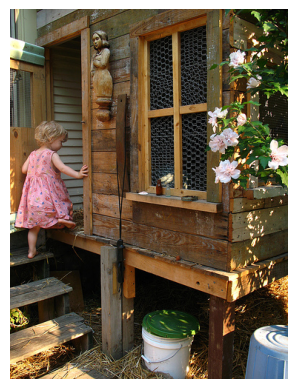

CAPTIONS - 
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [14]:
# Choose a random number, say 50

IMG_PATH = "/content/flickr_data/Flickr_Data/Images/"
image_id = captions[1].split('.')[0]

img = Image.open(IMG_PATH + image_id + ".jpg")
img = img.convert('RGB')
plt.imshow(img)
plt.axis("off")
plt.show()

print("CAPTIONS - ")
for caption in content[image_id]:
    print(caption)

In [15]:
captions[10].split('.')[0]

'1002674143_1b742ab4b8'

#Clean the data
So upto this point we have data in the dictionary formate as given.

data{'1002674143_1b742ab4b8':['caption 1','catptions 2','captions 3','captions 4']

In [16]:

def clean (data):
    # Convert all characters to lower case
    data = data.lower()

    # Convert all non-alphabet characters to ' '
    data = re.sub("[^a-z]+", " ", data)

    return data


In [17]:
for ID, caption_list in content.items():
    for i in range(len(caption_list)):
        content[ID][i] = clean(content[ID][i])

In [18]:
print(content[captions[1].split('.')[0]][-1])

a little girl in a pink dress going into a wooden cabin 


In [19]:
captions[1].split('.')[0]

'1000268201_693b08cb0e'

#Store the cleaned captions in a file "tokens_clean.txt" for future reference

In [20]:
with open ("/content/flickr_data/Flickr_Data/Flickr_TextData/tokens_clean.txt", "w") as file:
    file.write(str(content))

create vocabulary

In [21]:
vocabulary = set()
for key in content.keys():
        [vocabulary.update(d.split()) for d in content[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8441


save the cleaned ansers and image ids in teken.txt formate

In [22]:
path = '/content/cleaned.txt' #create file with name cleaned.txt

with open(path, 'w') as file:
  for key, caption in content.items():
    count = 0
    for cap in caption:
      file.write(f'{key}' + '.jpg' + f'#{count}\t' + cap + '\n')
      count += 1


In [23]:
train_images_path ='/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
doc_train = open(train_images_path,'r').read()
train = []
for img_pth in doc_train.split('\n'):
  if len(img_pth) > 1:# if it is not the end
    id, jpg = img_pth.split('.')
    train.append(id)


In [24]:
test_image_path = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
train_image_path = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
images_path = '/content/flickr_data/Flickr_Data/Images/'

Now we save all the training and testing images in train_img and test_img lists respectively

In [25]:

img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n')) #read images name

train_img = []
for i in img:
    if i[len(images_path):] in train_images:
        train_img.append(i)

In [26]:

test_images = set(open(test_image_path, 'r').read().strip().split('\n'))
test_img = []
for i in img:
    if i[len(images_path):] in test_images:
        test_img.append(i)

load the descriptions of the training images into a dictionary and add end and start to the sentence

In [27]:

new_descriptions = open('/content/cleaned.txt','r').read()
new_descriptions = new_descriptions[:-1]
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0].split('.')[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

all training captions in one list

In [28]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

Top k word sampling sample the word having occurance greater than 10

In [29]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1660


Now we create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length.



In [30]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

We also need to find out what the max length of a caption can be since we cannot have captions of arbitrary length.

In [31]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


#Glove Embeddings

The advantage of using Glove over Word2Vec is that GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors.


For our model, we will map all the words in our 38-word long caption to a 200-dimension vector using Glove.

In [32]:
#i will take this from kaggle
!kaggle datasets download -d incorpes/glove6b200d

 95% 245M/259M [00:02<00:00, 115MB/s]
100% 259M/259M [00:02<00:00, 121MB/s]


In [33]:
!unzip '/content/glove6b200d.zip'

Archive:  /content/glove6b200d.zip
  inflating: glove.6B.200d.txt       


In [34]:

embeddings_index = {}
f = open('/content/glove.6B.200d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs


make the matrix of shape (1660,200) consisting of our vocabulary and the 200-d vector

In [35]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim)) #1660 smaple each of 200 diamention (200,)
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#Model Building and Training

reshape the image into 299,299

In [36]:
model = InceptionV3(weights='imagenet') #trained on imageNet load complete model

96112376/96112376 [==============================] - 1s 0us/step


In [37]:
model_new = Model(model.input, model.layers[-2].output) #new model to have input like inception v3 input and finish the layer on the second last layer to extract the feature of image


In [38]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

Now we can go ahead and encode our training and testing images, i.e extract the images vectors of shape (2048,)

In [39]:
def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

training feature vectors

In [ ]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 251ms/step


In [ ]:


# Specify the file path to save the features
save_path = '/content/train_features.pkl'

# Save the dictionary using pickle
with open(save_path, 'wb') as file:
    pickle.dump(train_features, file)


In [47]:
# Load the saved features using pickle
save_path = '/content/train_features.pkl'
with open(save_path, 'rb') as file:
    train_features = pickle.load(file)


In [48]:
train_features['3650188378_cc8aea89f0.jpg']

array([0.23118539, 0.3302245 , 0.65621257, ..., 0.2757259 , 0.03068591,
       0.13467227], dtype=float32)

test feature vector

In [ ]:
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

1/1 [==============================] - 0s 245ms/step


In [ ]:


# Specify the file path to save the test features
test_save_path = '/content/test_features.pkl'

# Save the test dictionary using pickle
with open(test_save_path, 'wb') as file:
    pickle.dump(encoding_test, file)


In [49]:
# Load the saved features using pickle
save_path = '/content/test_features.pkl'
with open(save_path, 'rb') as file:
    encoding_test = pickle.load(file)

In [50]:
encoding_test['1056338697_4f7d7ce270.jpg']

array([0.45309195, 0.25754124, 0.11302748, ..., 1.1222596 , 0.3437773 ,
       1.0150545 ], dtype=float32)

Lets build model

We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps
1. Processing the sequence from the text
2. Extracting the feature vector from the image
3. Decoding the output using softmax by concatenating the above two layers

In [40]:
#to extract the image feature
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

In [41]:
#to extract the text sequence feature
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

In [42]:
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [43]:
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      332200      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

#traning model

we do not want to retrain the weights in our embedding layer (pre-trained Glove vectors).

In [44]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

Since our dataset has 6000 images and 40000 captions we will create a function that can train the data in batches.

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            #iterate over captions
            for desc in desc_list:
                # encode the sequence of word in captions
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 5
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/5
2000/2000 [==============================] - 1086s 540ms/step - loss: 3.7043
Epoch 2/5
2000/2000 [==============================] - 1064s 532ms/step - loss: 3.0471
Epoch 3/5
2000/2000 [==============================] - 1057s 528ms/step - loss: 2.8437
Epoch 4/5
2000/2000 [==============================] - 1067s 534ms/step - loss: 2.7247
Epoch 5/5
2000/2000 [==============================] - 1076s 538ms/step - loss: 2.6372


In [ ]:
pickle.dump(model , open('imagecaptioning.pk1' , 'wb'))

In [54]:
# Specify the path to the saved model file
model_path = '/content/imagecaptioning.pk1'

# Load the model from the pickled file
with open(model_path, 'rb') as file:
    model = pickle.load(file)


#Greedy and Beam Search

In [55]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

#Evaluation

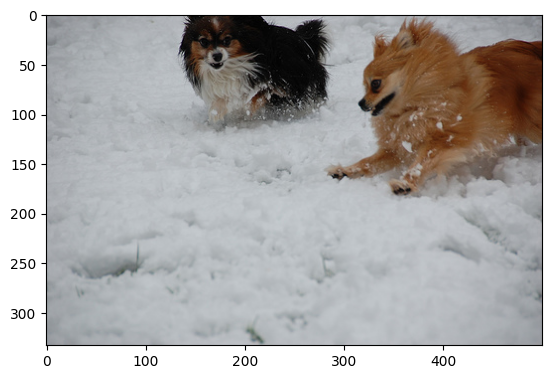

Beam Search, K = 3: a black and white dog runs through the snow
Beam Search, K = 5: a white dog runs through the snow
Beam Search, K = 7: a brown and white dog carries a stick in its mouth
Beam Search, K = 10: a brown and white dog carries a stick in its mouth


In [56]:
pic ='2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()


print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))